In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import nonlinear_QM_FPJPA as Fs
import wx_programs as wx
import bnc
from generator import *
from hardware_config import *
from values import *
from qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.rabi_ef_no_swap as rabi_ef_no_swap
import analysis.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
big_agilent_address = 'GPIB0::30::INSTR'
bnc.set_bnc_output(8.33, power_dBm=-2, bnc_addr=big_agilent_address)
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)



Qubit(ro_freq=6.7275, ROq3=6.583064, ge_ssm=-0.11, ge_time=52.17178532987394, qubit_thr=[-10000, -600], RO_IF=0.030850000000000044, ro_amp=0.6, qubit_id=q1, IQ_angle=205, ef_time=76.411, ef_amp=1, RO_LO=6.6247, ro_dur=4000, RO_LO_pwr=16, ROIF=0.10280000000000022, ef_ssm=-0.255, ge_amp=1.2)
Qubit(ro_freq=6.65555, ROq3=6.583064, ge_ssm=-0.152, ge_time=40.15374412400174, qubit_thr=[-10000, 1900], RO_IF=0.10280000000000022, ro_amp=0.4, qubit_id=q2, IQ_angle=85, ef_time=None, ef_amp=1, RO_LO=6.6247, ro_dur=4000, RO_LO_pwr=16, ROIF=0.030850000000000044, ef_ssm=-0.224, ge_amp=1.2)


In [3]:
spyder_IQ = pd.read_csv('rabi_raw_IQ_data.csv')
# Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
spyder_IQ = classifier.classify(spyder_IQ)
spyder_states = spyder_IQ['predicted']
spyder_reps =10000
# Reshape the predicted states.
# (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
#  where each row corresponds to a time step and holds all the state measurements for that step.)
spyder_states_reshaped= classifier.reshape_for_exp(spyder_states, spyder_reps, 51)
spyder_probabilties = classifier.probabilities(spyder_states_reshaped)
spyder_population = classifier.population(spyder_states_reshaped)
spyder_sweep_time = 50000
# Compute time values as the index for the DataFrame.
times = np.linspace(0, spyder_sweep_time/1000, 51)

# Build a DataFrame that holds the probability vs. time.
spyder_df_prob = pd.DataFrame({
    'time': times,
    'P_f': spyder_probabilties['P_f'],
    'P_e': spyder_probabilties['P_e'],
    'P_g': spyder_probabilties['P_g']
}, index=times)

In [4]:
def run_rabi_ef_swap(q1: object, q2: object, general_vals_dict: dict,
                     num_steps: int, sweep_time: float,
                     swap_freq: float, swap_time: float, reps: int):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.
    
    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as 
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.rabi_ef_swap(q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time)
    wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"],
                                       offset=general_vals_dict["wx_offs"])
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(q1, q2,
                                num_patterns=num_steps,
                                num_records_per_pattern=reps,
                                verbose=True)
    
    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]
    
    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({
        "I1": I1_raw,
        "Q1": Q1_raw,
        "I2": I2_raw,
        "Q2": Q2_raw
    })
    
    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified['predicted']
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)
    
    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time/1000, num_steps)
    
    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame({
        'time': times,
        'P_f': probabilties['P_f'],
        'P_e': probabilties['P_e'],
        'P_g': probabilties['P_g']
    }, index=times)

    df_pop = pd.DataFrame({
        'time': times,
        'Pop_f': population['Pop_f'],
        'Pop_e': population['Pop_e'],
        'Pop_g': population['Pop_g']
    }, index=times)
    
    return df_prob,df_pop, values


def sweep_J(J_start: float, J_stop: float, J_steps: int):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a 
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.
    
    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as 
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    probs_folder = os.path.join("sweep_J_data", "probs")
    values_folder = os.path.join("sweep_J_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    num_steps = 51
    reps = 12000
    sweep_time =50000
    swap_freq=-.021
    swap_time=213

    # Create an array of frequency values
    J_vals = np.linspace(J_start, J_stop, J_steps)
    
    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals ={}
    # Loop over frequencies and populate the dictionary
    for J in J_vals:
        prob_filename = os.path.join(probs_folder, f"j={J}.pkl")
        values_filename = os.path.join(values_folder, f"j={J}.pkl")
        
        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[J] = df_prob
            return_vals[J] = values
            continue  # Skip to the next J value
        
        a_to_J = (((2*np.pi)/(2*(2*q1.ef_time*10**-3))))#if J is in units of rad/micros 
        J_to_a = 1/a_to_J
        q1.ef_ssm =-0.25275
        ef_amp=J * J_to_a 
        q1.ef_amp = ef_amp 
        df_prob, df_pop, values = run_rabi_ef_swap(q1, q2, general_vals_dict, num_steps,
                                   sweep_time, swap_freq, swap_time, reps)
        # Populate the dictionary at the corresponding frequency key
        return_dict[J] = df_prob
        return_vals[J] = values

        # Create filenames with the current J value
        prob_filename = os.path.join(probs_folder, f"j={J}.pkl")
        values_filename = os.path.join(values_folder, f"j={J}.pkl")
        
        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
        
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)

    return return_dict, return_vals


In [5]:
def run_rabi_ef_no_swap(q1: object, q2: object, general_vals_dict: dict, ef_amp:float,
                     num_steps: int, sweep_time: float, reps: int):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.
    
    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as 
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_no_swap.rabi_ef_no_swap(q1, q2, general_vals_dict,ef_amp, num_steps, sweep_time,)
    wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"],
                                       offset=general_vals_dict["wx_offs"])
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(q1, q2,
                                num_patterns=num_steps,
                                num_records_per_pattern=reps,
                                verbose=True)
    
    
    
    return  values

def run_swap(q1: object, q2: object, general_vals_dict: dict, swap_freq: float,
                     num_steps: int, sweep_time: float, reps: int):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.
    
    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as 
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.swap(q1, q2, general_vals_dict, num_steps, sweep_time,swap_freq)
    wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"],
                                       offset=general_vals_dict["wx_offs"])
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(q1, q2,
                                num_patterns=num_steps,
                                num_records_per_pattern=reps,
                                verbose=True)
    
    
    
    return  values



writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 87.381393 sec
Captured 200 buffers (2.288817 buffers per sec)
Captured 614400 records (7031.245183 records per sec)
Transferred 10066329600 bytes (115199921.081921 bytes per sec)


<Figure size 800x800 with 0 Axes>

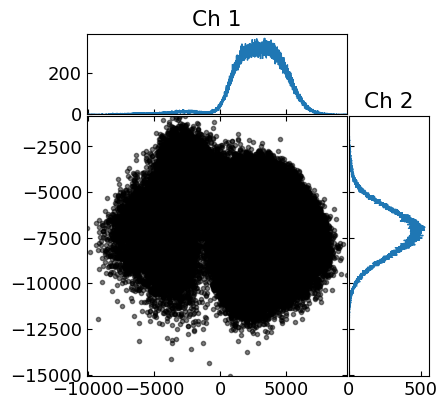

<Figure size 800x800 with 0 Axes>

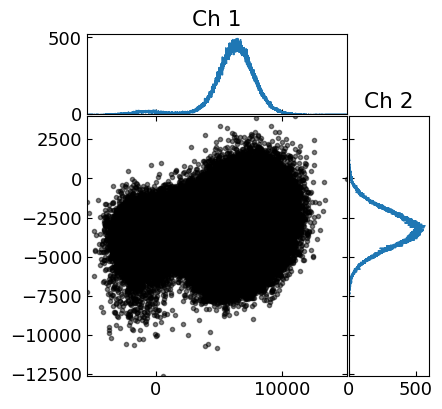

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 76.201431 sec
Captured 200 buffers (2.624623 buffers per sec)
Captured 614400 records (8062.840706 records per sec)
Transferred 10066329600 bytes (132101582.124422 bytes per sec)


<Figure size 800x800 with 0 Axes>

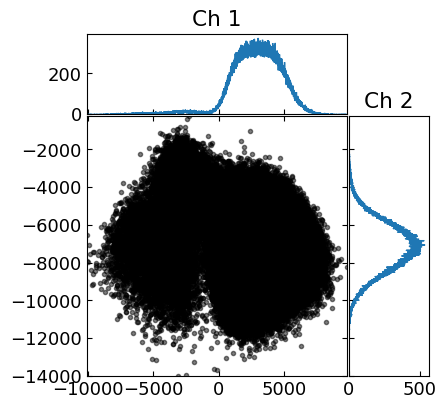

<Figure size 800x800 with 0 Axes>

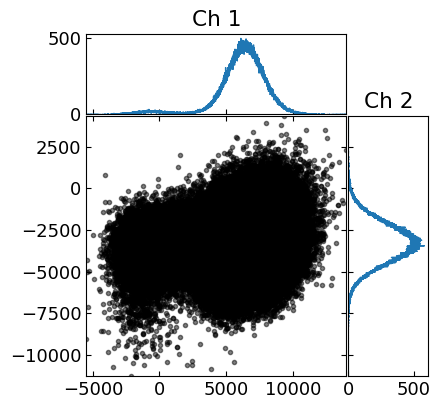

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 72.536404 sec
Captured 200 buffers (2.757236 buffers per sec)
Captured 614400 records (8470.229609 records per sec)
Transferred 10066329600 bytes (138776241.905757 bytes per sec)


<Figure size 800x800 with 0 Axes>

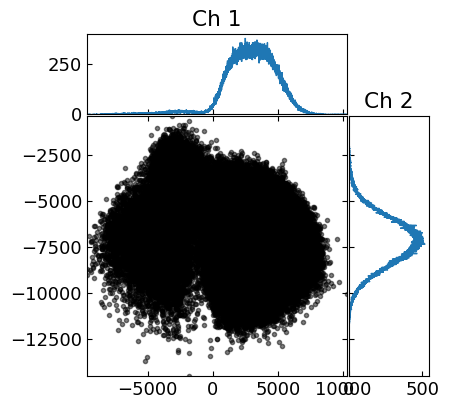

<Figure size 800x800 with 0 Axes>

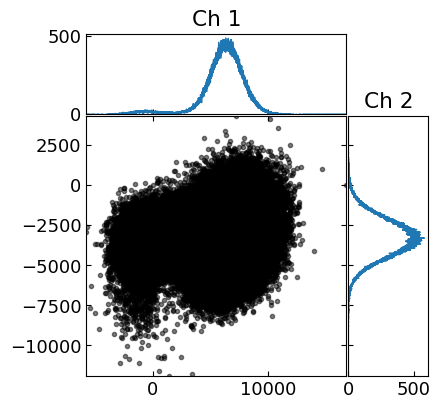

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 83.020860 sec
Captured 200 buffers (2.409033 buffers per sec)
Captured 614400 records (7400.549676 records per sec)
Transferred 10066329600 bytes (121250605.887927 bytes per sec)


<Figure size 800x800 with 0 Axes>

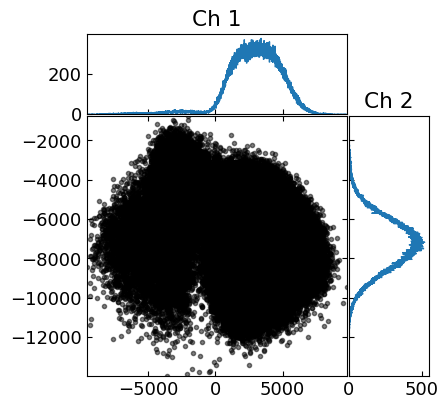

<Figure size 800x800 with 0 Axes>

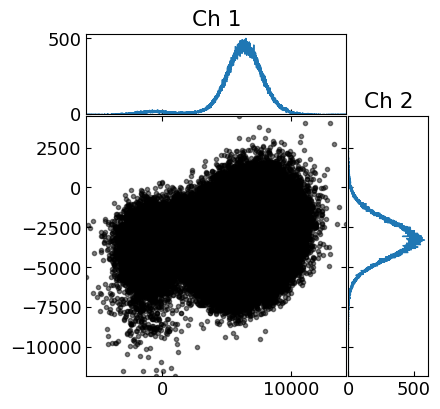

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 70.359442 sec
Captured 200 buffers (2.842547 buffers per sec)
Captured 614400 records (8732.303477 records per sec)
Transferred 10066329600 bytes (143070060.172259 bytes per sec)


<Figure size 800x800 with 0 Axes>

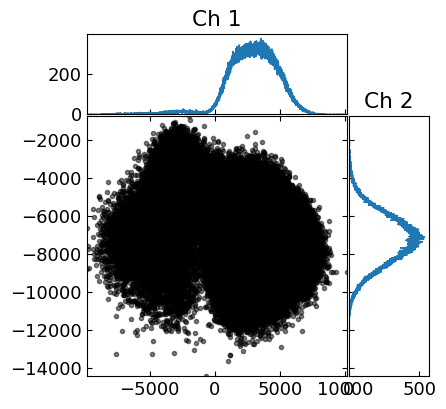

<Figure size 800x800 with 0 Axes>

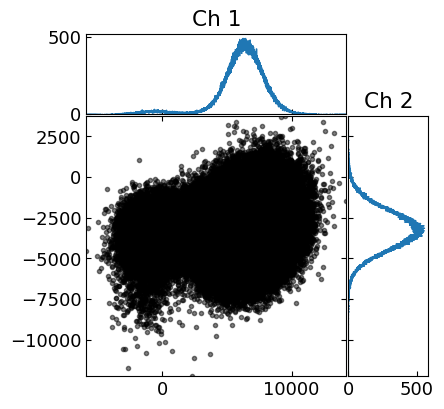

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 77.421951 sec
Captured 200 buffers (2.583247 buffers per sec)
Captured 614400 records (7935.733855 records per sec)
Transferred 10066329600 bytes (130019063.479574 bytes per sec)


<Figure size 800x800 with 0 Axes>

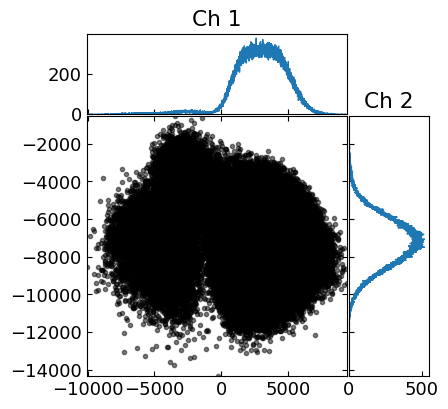

<Figure size 800x800 with 0 Axes>

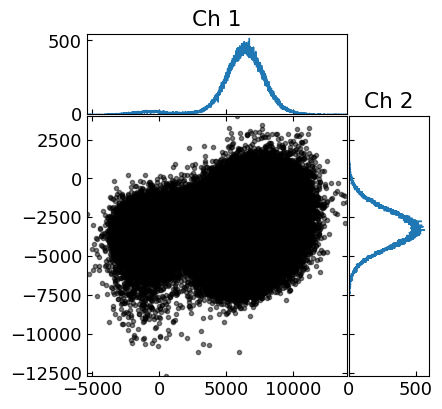

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 77.758521 sec
Captured 200 buffers (2.572065 buffers per sec)
Captured 614400 records (7901.384869 records per sec)
Transferred 10066329600 bytes (129456289.690825 bytes per sec)


<Figure size 800x800 with 0 Axes>

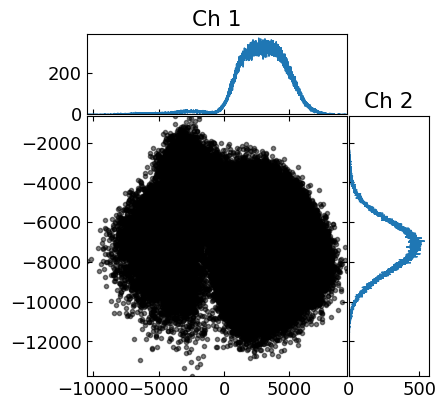

<Figure size 800x800 with 0 Axes>

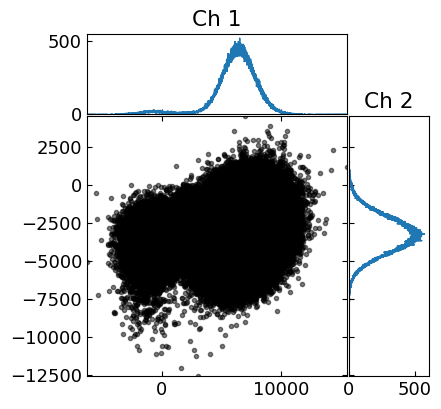

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 72.587544 sec
Captured 200 buffers (2.755294 buffers per sec)
Captured 614400 records (8464.262081 records per sec)
Transferred 10066329600 bytes (138678469.942610 bytes per sec)


<Figure size 800x800 with 0 Axes>

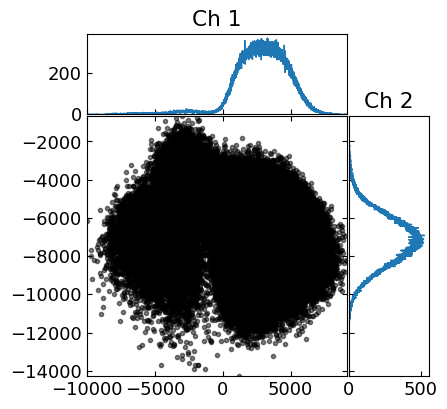

<Figure size 800x800 with 0 Axes>

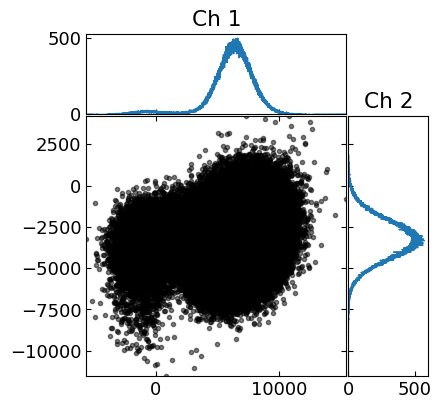

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 80.065944 sec
Captured 200 buffers (2.497941 buffers per sec)
Captured 614400 records (7673.674549 records per sec)
Transferred 10066329600 bytes (125725483.802878 bytes per sec)


<Figure size 800x800 with 0 Axes>

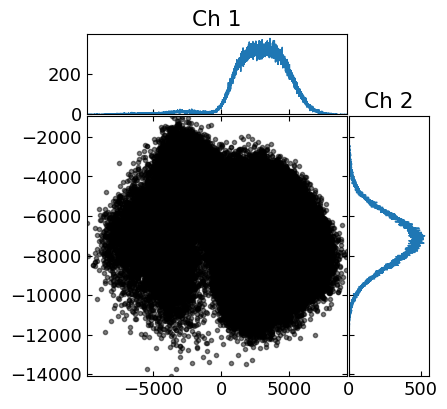

<Figure size 800x800 with 0 Axes>

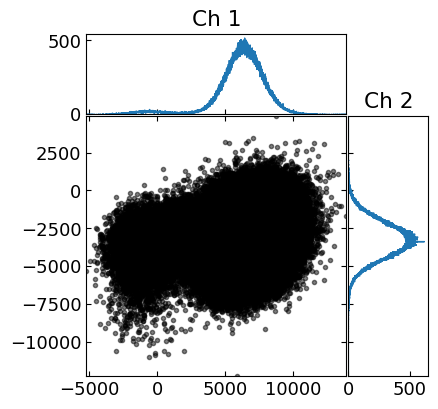

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 74.121398 sec
Captured 200 buffers (2.698276 buffers per sec)
Captured 614400 records (8289.104345 records per sec)
Transferred 10066329600 bytes (135808685.585874 bytes per sec)


<Figure size 800x800 with 0 Axes>

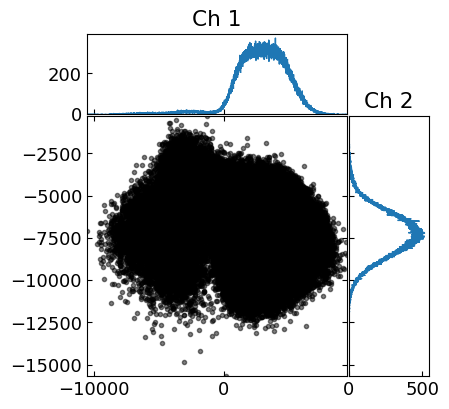

<Figure size 800x800 with 0 Axes>

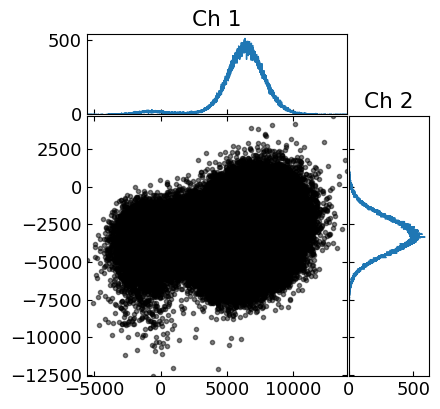

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 78.676736 sec
Captured 200 buffers (2.542047 buffers per sec)
Captured 614400 records (7809.169883 records per sec)
Transferred 10066329600 bytes (127945439.355814 bytes per sec)


<Figure size 800x800 with 0 Axes>

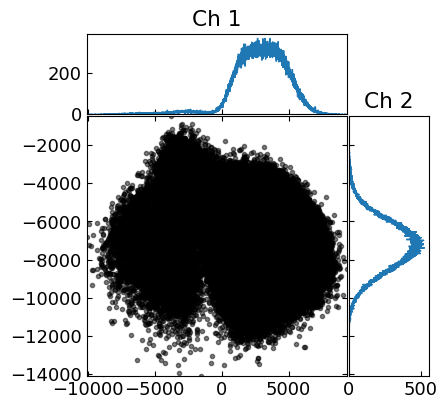

<Figure size 800x800 with 0 Axes>

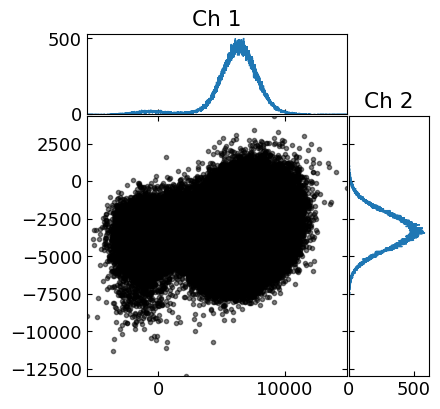

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 73.595151 sec
Captured 200 buffers (2.717570 buffers per sec)
Captured 614400 records (8348.376137 records per sec)
Transferred 10066329600 bytes (136779794.633237 bytes per sec)


<Figure size 800x800 with 0 Axes>

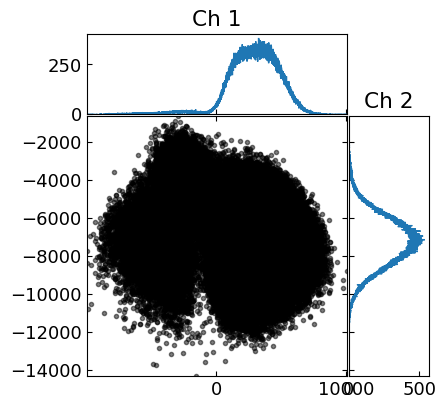

<Figure size 800x800 with 0 Axes>

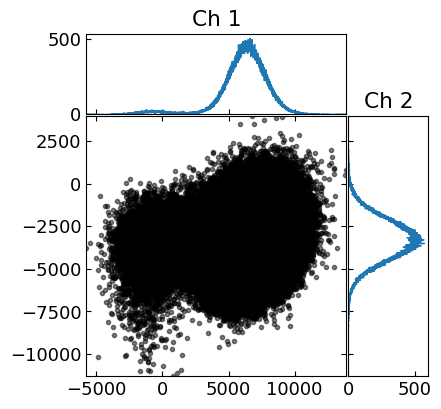

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 70.279120 sec
Captured 200 buffers (2.845795 buffers per sec)
Captured 614400 records (8742.283600 records per sec)
Transferred 10066329600 bytes (143233574.500856 bytes per sec)


<Figure size 800x800 with 0 Axes>

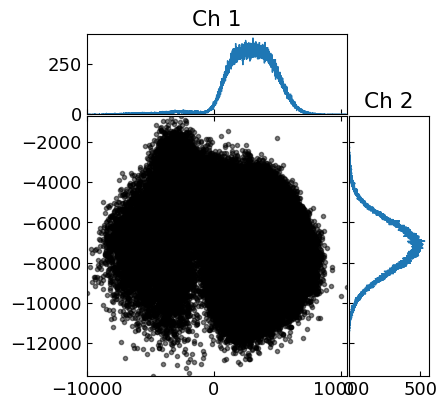

<Figure size 800x800 with 0 Axes>

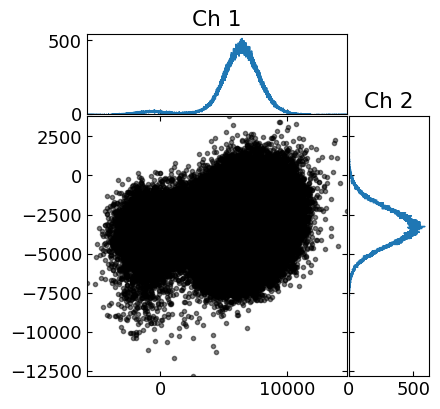

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 85.635687 sec
Captured 200 buffers (2.335475 buffers per sec)
Captured 614400 records (7174.578952 records per sec)
Transferred 10066329600 bytes (117548301.547623 bytes per sec)


<Figure size 800x800 with 0 Axes>

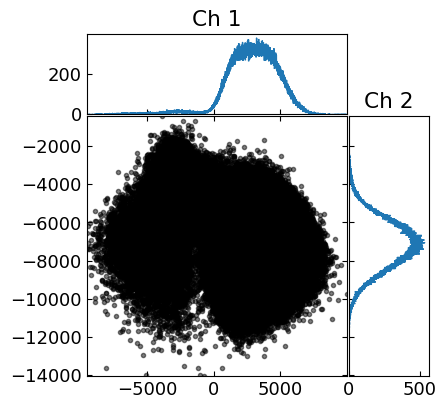

<Figure size 800x800 with 0 Axes>

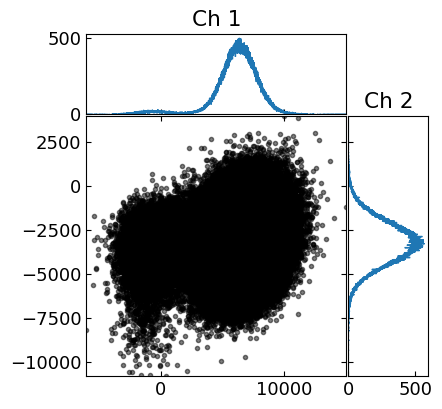

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 71.575156 sec
Captured 200 buffers (2.794266 buffers per sec)
Captured 614400 records (8583.984088 records per sec)
Transferred 10066329600 bytes (140639995.304183 bytes per sec)


<Figure size 800x800 with 0 Axes>

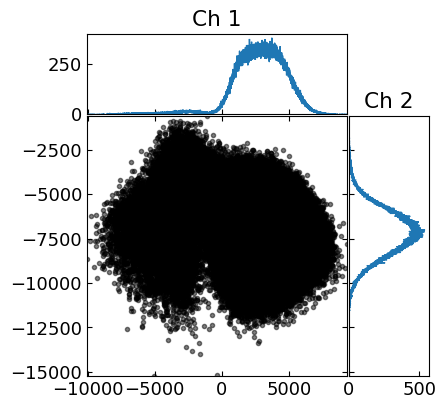

<Figure size 800x800 with 0 Axes>

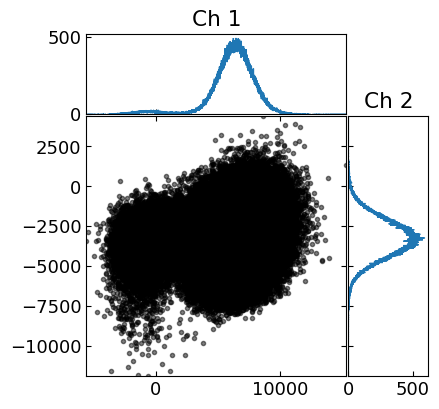

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 81.825536 sec
Captured 200 buffers (2.444225 buffers per sec)
Captured 614400 records (7508.658464 records per sec)
Transferred 10066329600 bytes (123021860.279720 bytes per sec)


<Figure size 800x800 with 0 Axes>

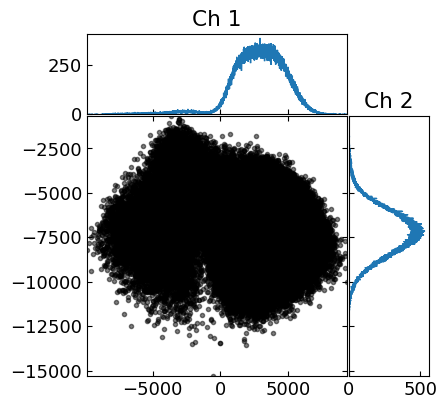

<Figure size 800x800 with 0 Axes>

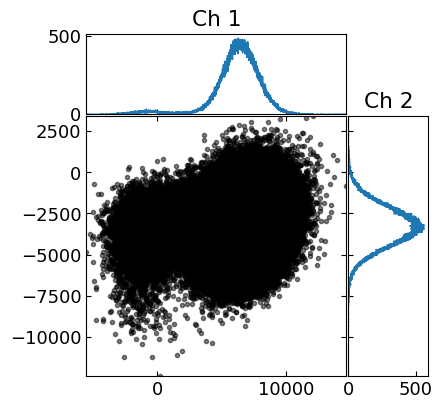

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 74.188787 sec
Captured 200 buffers (2.695825 buffers per sec)
Captured 614400 records (8281.574925 records per sec)
Transferred 10066329600 bytes (135685323.577137 bytes per sec)


<Figure size 800x800 with 0 Axes>

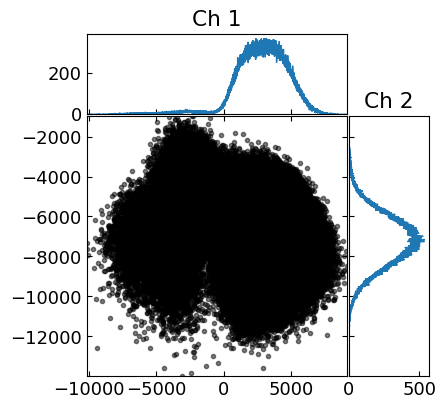

<Figure size 800x800 with 0 Axes>

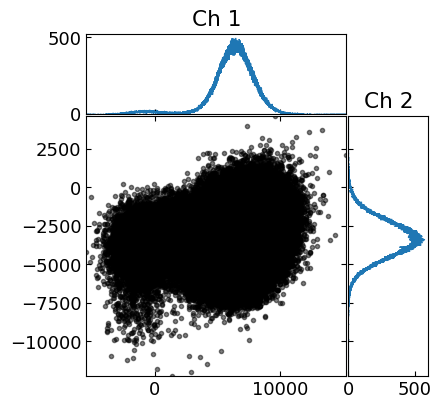

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 75.280546 sec
Captured 200 buffers (2.656729 buffers per sec)
Captured 614400 records (8161.471124 records per sec)
Transferred 10066329600 bytes (133717542.890499 bytes per sec)


<Figure size 800x800 with 0 Axes>

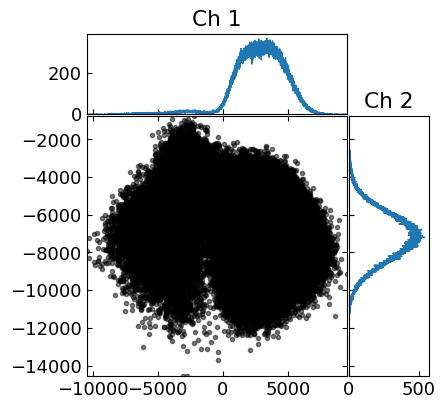

<Figure size 800x800 with 0 Axes>

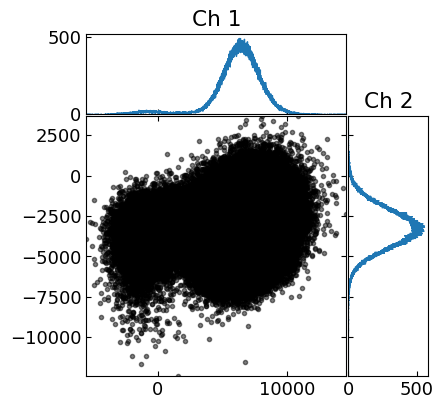

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 67.212025 sec
Captured 200 buffers (2.975658 buffers per sec)
Captured 614400 records (9141.221359 records per sec)
Transferred 10066329600 bytes (149769770.739751 bytes per sec)


<Figure size 800x800 with 0 Axes>

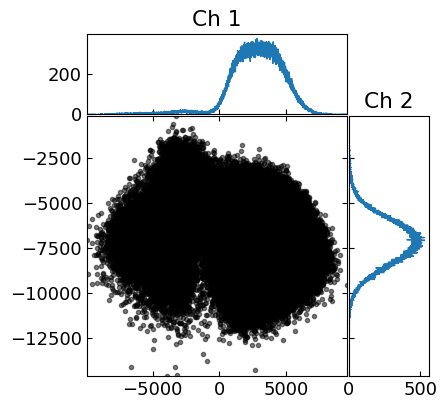

<Figure size 800x800 with 0 Axes>

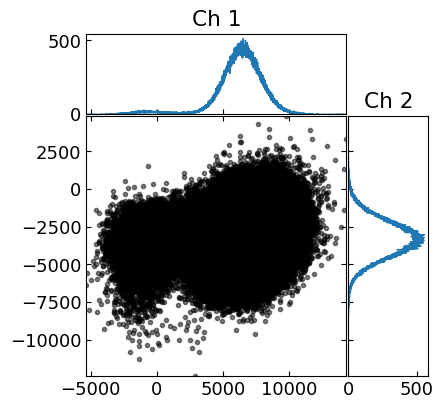

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 65.683526 sec
Captured 200 buffers (3.044904 buffers per sec)
Captured 614400 records (9353.943596 records per sec)
Transferred 10066329600 bytes (153255011.880228 bytes per sec)


<Figure size 800x800 with 0 Axes>

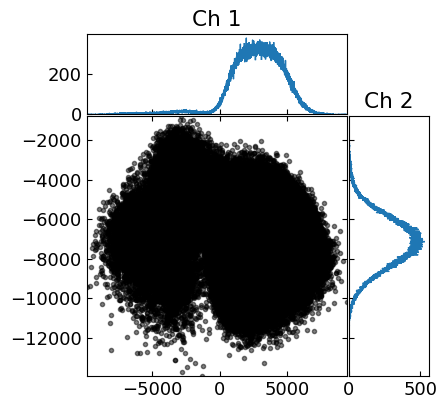

<Figure size 800x800 with 0 Axes>

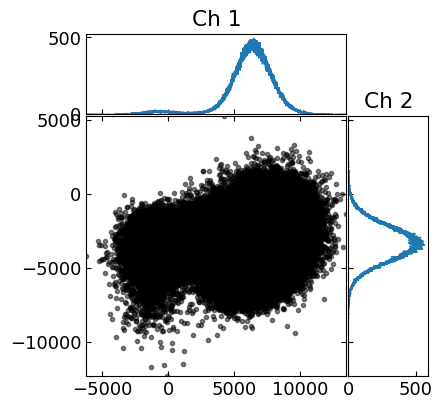

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 65.064503 sec
Captured 200 buffers (3.073873 buffers per sec)
Captured 614400 records (9442.936895 records per sec)
Transferred 10066329600 bytes (154713078.086051 bytes per sec)


<Figure size 800x800 with 0 Axes>

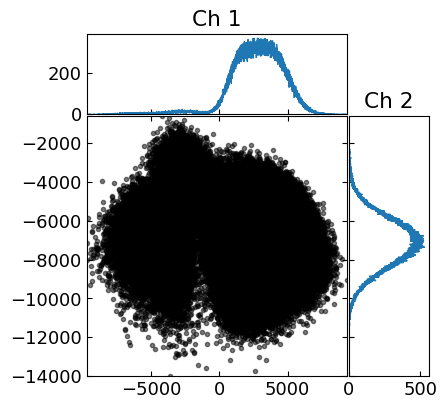

<Figure size 800x800 with 0 Axes>

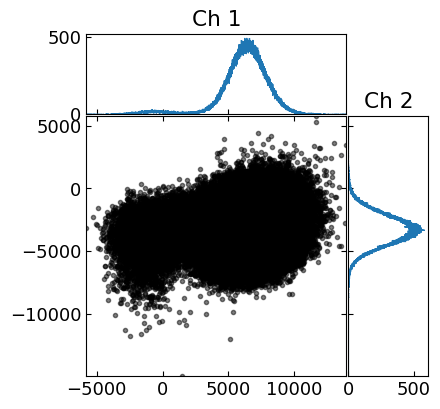

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 64.634382 sec
Captured 200 buffers (3.094328 buffers per sec)
Captured 614400 records (9505.776731 records per sec)
Transferred 10066329600 bytes (155742645.961763 bytes per sec)


<Figure size 800x800 with 0 Axes>

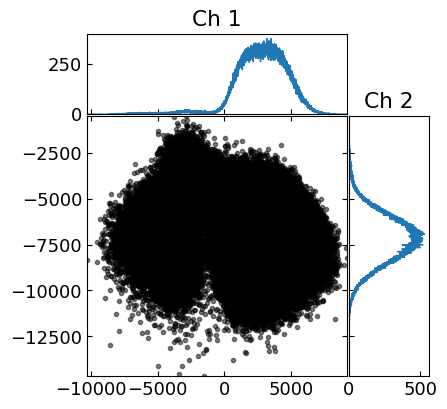

<Figure size 800x800 with 0 Axes>

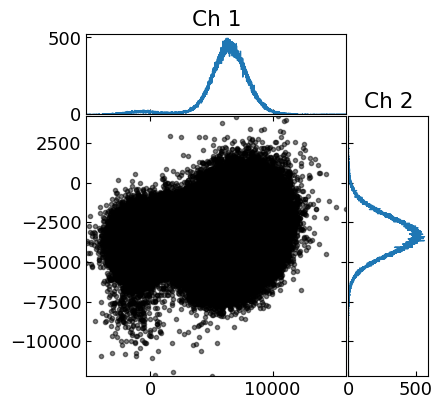

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 64.711100 sec
Captured 200 buffers (3.090660 buffers per sec)
Captured 614400 records (9494.507075 records per sec)
Transferred 10066329600 bytes (155558003.914745 bytes per sec)


<Figure size 800x800 with 0 Axes>

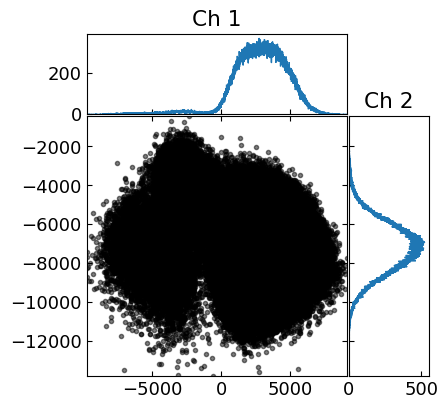

<Figure size 800x800 with 0 Axes>

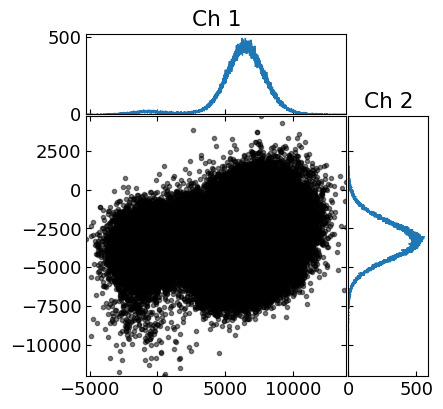

In [6]:
# num_steps = 51
# reps = 1200
# sweep_time =50000
# swap_freq=-.021
# swap_time=213


# check_df, pop_df, values = run_rabi_ef_swap(q1, q2, general_vals_dict,
#                      num_steps, sweep_time,
#                      swap_freq, swap_time, reps)

# values = run_swap(q1, q2, general_vals_dict,swap_freq , num_steps,swap_time, reps)
#                                    sweep_time, reps)
# df_prob, df_pop, values = run_rabi_ef_no_swap(q1, q2, general_vals_dict,ef_amp , num_steps,
#                                    sweep_time, reps)
J_dict , vals_dict = sweep_J(0,0.5,51)

<Figure size 960x720 with 0 Axes>

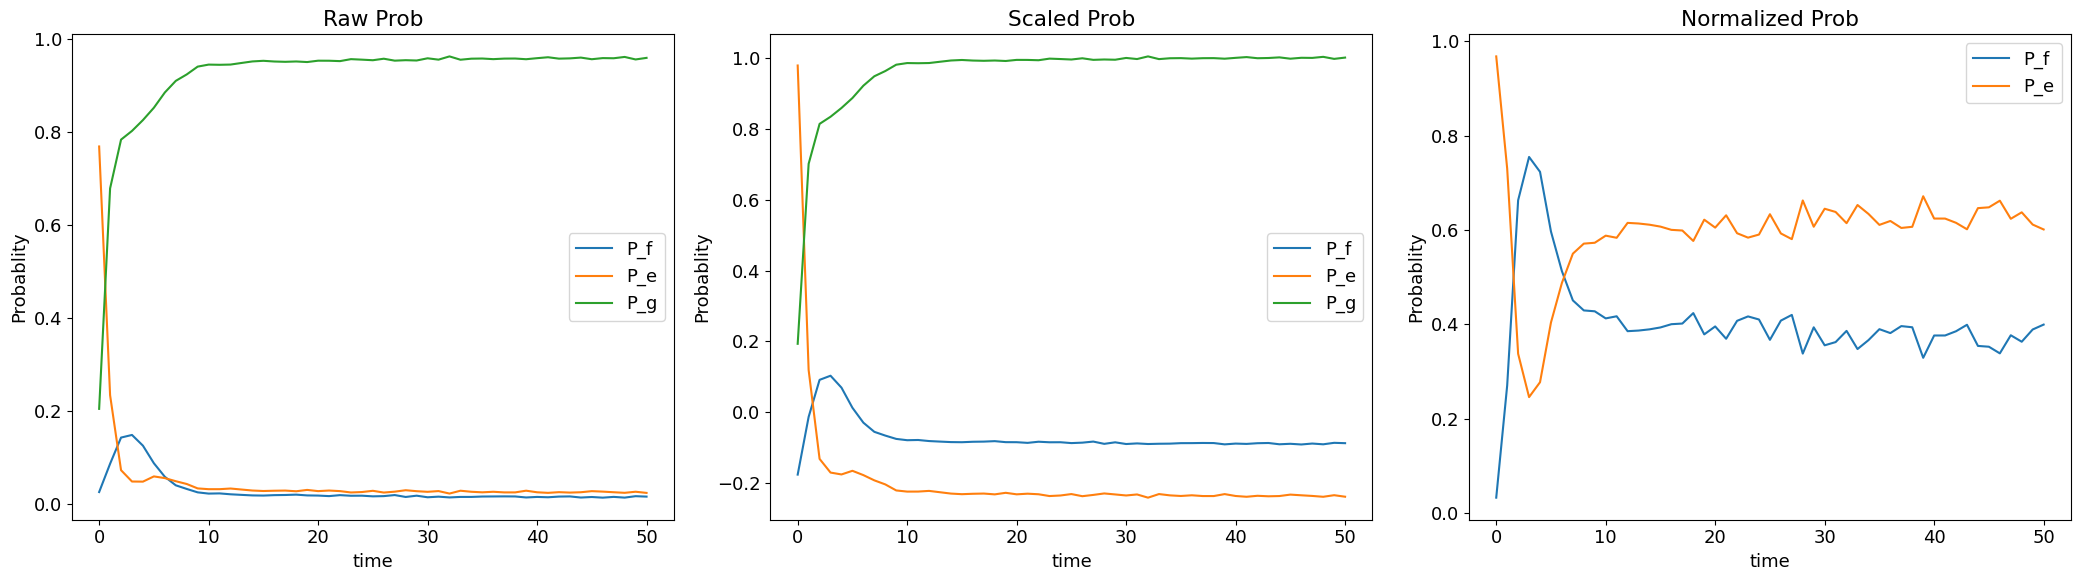

In [7]:
scale_matrix = np.array([[ 1.04489856, -0.02682748, -0.01807108],
       [-0.28202628,  1.35096177, -0.06893549],
       [-0.10815337, -0.2466758 ,  1.35482917]])

measured_pop = np.array([J_dict[0.4]['P_g'], J_dict[0.4]['P_e'], J_dict[0.4]['P_f']])
scaled_p = np.matmul(scale_matrix, measured_pop)
scaled_df = pd.DataFrame({'time': J_dict[0.4]['time'], 'P_g': scaled_p[0], 'P_e': scaled_p[1], 'P_f': scaled_p[2]})
normalization_val = J_dict[0.4]['P_f'] + J_dict[0.4]['P_e']
normalized_df = pd.DataFrame({'time':J_dict[0.4]['time'], 'P_f':J_dict[0.4]['P_f']/normalization_val,'P_e':J_dict[0.4]['P_e']/normalization_val, "P_g":J_dict[0.4]['P_g']/normalization_val })
keys = ['P_f', 'P_e', "P_g"]
plt.figure(dpi = 150)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for key in keys:
    sns.lineplot(
        data=J_dict[0.4],
        x="time",
        y=key,
        ax=axes[0],
        label = key
    )
    sns.lineplot(
        data=scaled_df,
        x="time",
        y=key,
        ax=axes[1],
        label = key
    )
    if 'P_g' != key:
        sns.lineplot(
            data=normalized_df,
            x="time",
            y=key,
            ax=axes[2],
            label = key
        )
axes[1].set_xlabel("time")
axes[1].set_ylabel("Probablity")
axes[1].set_title("Scaled Prob")
axes[1].legend()
axes[0].set_xlabel("time")
axes[0].set_ylabel("Probablity")
axes[0].set_title("Raw Prob")
axes[0].legend()
axes[2].set_xlabel("time")
axes[2].set_ylabel("Probablity")
axes[2].set_title("Normalized Prob")
axes[2].legend()
# Adjust layout for better spacing
plt.tight_layout()

In [8]:
J_dict

{0.0:       time       P_f       P_e       P_g
 0.0    0.0  0.027750  0.764000  0.208250
 1.0    1.0  0.026750  0.267500  0.705750
 2.0    2.0  0.024833  0.106500  0.868667
 3.0    3.0  0.019083  0.053167  0.927750
 4.0    4.0  0.018167  0.040083  0.941750
 5.0    5.0  0.017917  0.032833  0.949250
 6.0    6.0  0.017750  0.029500  0.952750
 7.0    7.0  0.016250  0.033083  0.950667
 8.0    8.0  0.018833  0.029750  0.951417
 9.0    9.0  0.015000  0.029917  0.955083
 10.0  10.0  0.017500  0.031417  0.951083
 11.0  11.0  0.014917  0.030667  0.954417
 12.0  12.0  0.018250  0.029500  0.952250
 13.0  13.0  0.016000  0.028917  0.955083
 14.0  14.0  0.018000  0.029583  0.952417
 15.0  15.0  0.016500  0.028000  0.955500
 16.0  16.0  0.014250  0.027583  0.958167
 17.0  17.0  0.017583  0.027167  0.955250
 18.0  18.0  0.016167  0.029250  0.954583
 19.0  19.0  0.014667  0.027833  0.957500
 20.0  20.0  0.015167  0.029667  0.955167
 21.0  21.0  0.015583  0.028750  0.955667
 22.0  22.0  0.015500  0.0325

In [9]:
# # Retrieve raw IQ data from the acquired values
# values = vals_dict[0]
# I1_raw = values.rec_avg_vs_pats_1[0]
# Q1_raw = values.rec_avg_vs_pats_1[1]
# I2_raw = values.rec_avg_vs_pats_2[0]
# Q2_raw = values.rec_avg_vs_pats_2[1]

# # Build a DataFrame from the IQ data for classification
# IQ_df = pd.DataFrame({
#     "I1": I1_raw,
#     "Q1": Q1_raw,
#     "I2": I2_raw,
#     "Q2": Q2_raw
# })
# Spyder_IQ = pd.read_csv('IQ_data.csv')
# plt.figure(dpi = 200)
# fig, axes = plt.subplots( 2,2, figsize = (14,14))
# # axes[0,0].plot(Spyder_IQ['I1'])
# # axes[0,1].plot(Spyder_IQ['Q1'])
# # axes[1,0].plot(Spyder_IQ['I2'])
# # axes[1,1].plot(Spyder_IQ['Q2'])
# axes[0,0].plot(IQ_df['I1'])
# axes[0,1].plot(IQ_df['Q1'])
# axes[1,0].plot(IQ_df['I2'])
# axes[1,1].plot(Spyder_IQ['Q2'])
# axes[0,0].set_title('I1')
# axes[0,1].set_title('Q1')
# axes[1,0].set_title('I2')
# axes[1,1].set_title('Q2')

In [10]:
scale_matrix = np.array([[ 1.04489856, -0.02682748, -0.01807108],
       [-0.28202628,  1.35096177, -0.06893549],
       [-0.10815337, -0.2466758 ,  1.35482917]])
# values = vals_dict[0]
P_f = values.prob_vs_pats_1[1]
P_e = values.prob_vs_pats_2[1]
P_g2 = values.prob_vs_pats_2[0]
P_g1 = values.prob_vs_pats_1[0]
spyder_df = pd.read_csv('prob_v_time.csv')
normalization_val = P_f+ P_e
thresh_df = pd.DataFrame({'time':J_dict[0]['time'], 'P_f':P_f, "P_e":P_e, "P_g1":P_g1,"P_g2":P_g2})
#normalized_df = pd.DataFrame({'time':J_dict[0]['time'], 'P_f':thresh_df['P_f']/normalization_val,'P_e':thresh_df['P_e']/normalization_val, "P_g":thresh_df['P_g']/normalization_val })
keys = ['P_f', 'P_e', 'P_g']
plt.figure(dpi = 150)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for key in keys:
    sns.lineplot(
        data=J_dict[0],
        x="time",
        y=key,
        ax=axes[0],
        label = key
    )
    sns.lineplot(
            data=spyder_df_prob,
            x="time",
            y=key,
            ax=axes[2],
            label = key
        )
    if 'P_g' != key:
        # sns.lineplot(
        #     data=spyder_df,
        #     x="time",
        #     y=key,
        #     ax=axes[2],
        #     label = key
        # )
        sns.lineplot(
            data=thresh_df,
            x="time",
            y=key,
            ax=axes[1],
            label = key
        )
for new_key in ['P_g1', 'P_g2']:
    # sns.lineplot(data=spyder_df,
    #             x='time',
    #             y = new_key,
    #             ax = axes[2],
    #             label = new_key)
    sns.lineplot(data=thresh_df,
                x='time',
                y = new_key,
                ax = axes[1],
                label = new_key)

axes[1].set_xlabel("time")
axes[1].set_ylabel("Probablity")
axes[1].set_title("Threshold Prob")
axes[1].legend()
axes[0].set_xlabel("time")
axes[0].set_ylabel("Probablity")
axes[0].set_title("ML Prob")
axes[0].legend()
axes[2].set_xlabel("time")
axes[2].set_ylabel("Probablity")
axes[2].set_title("Spyder Prob")
axes[2].legend()

for i in range(3):
    axes[i].set_ylim([0,1])
# Adjust layout for better spacing
plt.tight_layout()



NameError: name 'values' is not defined

In [ ]:

# Retrieve raw IQ data from the acquired values
I1_raw = values.rec_readout_1[0][0:reps*num_steps]
Q1_raw = values.rec_readout_1[1][0:reps*num_steps]
I2_raw = values.rec_readout_2[0][0:reps*num_steps]
Q2_raw = values.rec_readout_2[1][0:reps*num_steps]

# Build a DataFrame from the IQ data for classification
IQ_df = pd.DataFrame({
    "I1": I1_raw,
    "Q1": Q1_raw,
    "I2": I2_raw,
    "Q2": Q2_raw
})
# Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
classified = classifier.classify(IQ_df)

In [ ]:
dir(values)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bins_1',
 'bins_2',
 'counts_1',
 'counts_2',
 'n_readout_1',
 'n_readout_2',
 'n_vs_pats_1',
 'n_vs_pats_2',
 'prob_vs_pats_1',
 'prob_vs_pats_2',
 'rec_all',
 'rec_all_het_1',
 'rec_all_het_2',
 'rec_avg_all',
 'rec_avg_vs_pats_1',
 'rec_avg_vs_pats_2',
 'rec_readout_1',
 'rec_readout_2',
 'rec_readout_vs_pats_1',
 'rec_readout_vs_pats_2']

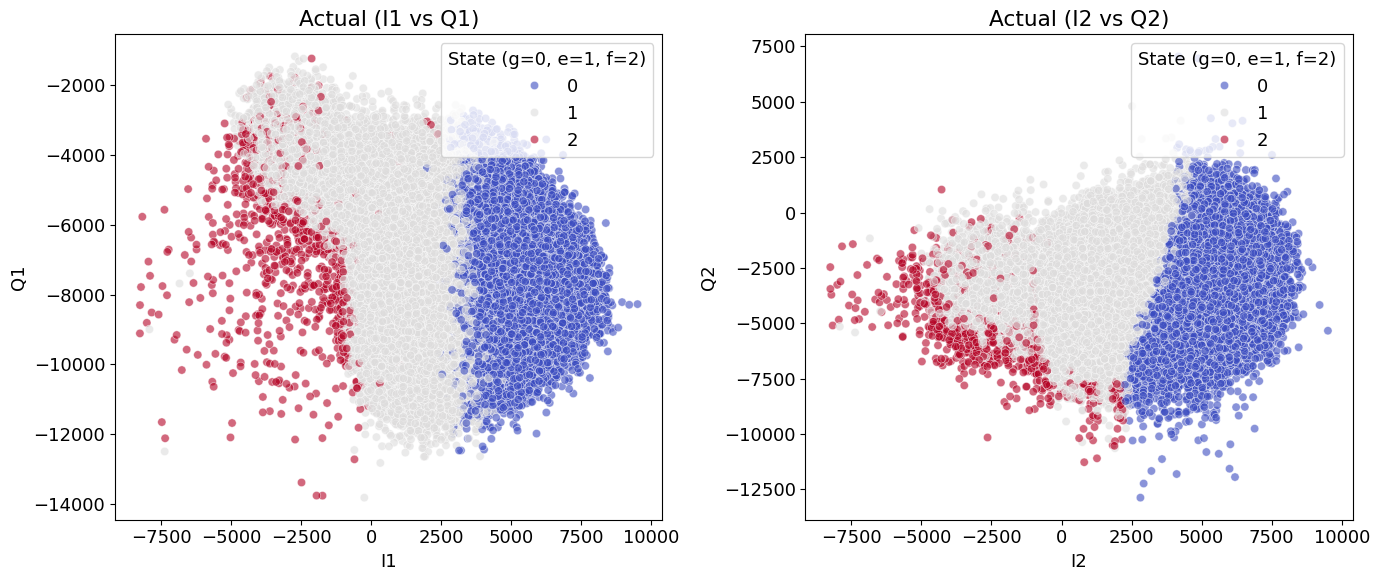

In [ ]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
time_step = 49
data_cut =spyder_IQ.copy() #IQ_df.iloc[time_step * reps: time_step*reps + reps]
# First subplot: I1 vs Q1
sns.scatterplot(
    data=data_cut,
    x="I1",
    y="Q1",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Actual (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)", loc = 'upper right')

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=data_cut,
    x="I2",
    y="Q2",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Actual (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)", loc = 'upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()